In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
    print(repo_path)
    
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None
exp_path = Path.cwd().resolve() # path to the experiment folder

print(f"Repo Path: {repo_path}")
print(f"Experiment Path: {exp_path}")

#Libraries
import yaml
import math
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    ToTensor,
    Normalize,
    InterpolationMode,
)
import wandb
import datasets, diffusers
from diffusers import (
    UNet2DModel,
    DDPMScheduler,
)   
from diffusers import DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available
import logging
from accelerate.logging import get_logger
from accelerate import Accelerator

# extra
from packaging import version

# import the MRIDataset class from the dataset folder
from dataset.build_dataset import MRIDataset

/home/benet/tfg/experiments
/home/benet/tfg
Repo Path: /home/benet/tfg
Experiment Path: /home/benet/tfg/experiments/latent


In [2]:
### 0. General setup
# load the config file
config_path = exp_path / 'config_latent.yaml' # configuration file path (beter to call it from the args parser)
with open(config_path) as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)


In [3]:
from torch.utils.data import Dataset

# Custom dataset
class MRIDataset(Dataset):
    def __init__(self, data_dir, transform=None, latents=False, RGB=False):
        self.data_dir = data_dir
        self.transform = transform
        self.latents = latents
        self.RGB = RGB
        if latents:
            self.image_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".npy")])
        else:
            self.image_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".png")])

    def __len__(self):
        return len(self.image_files) // 4 if self.latents else len(self.image_files)

    def __getitem__(self, idx):
        if self.latents:
            # Load four consecutive images as one sample
            img_paths = self.image_files[idx * 4 : (idx + 1) * 4]
            images = [np.load(os.path.join(self.data_dir, img_path)) for img_path in img_paths]

            if self.transform:
                images = [self.transform(img) for img in images]
            # Stack images along the channel dimension (4, 64, 64)
            latents = torch.cat(images, dim=0)
            return latents  # Shape: (4, 64, 64)

        else:    
            img_path = os.path.join(self.data_dir, self.image_files[idx])
            image = Image.open(img_path).convert("L")  # Convert to grayscale

            if self.RGB:
                image = image.convert("RGB")  # Convert to 3-channel RGB
            if self.transform:
                image = self.transform(image)

            return image    

In [4]:
### 1. Dataset loading and preprocessing
# Dataset loading
data_dir = repo_path / config['processing']['dataset']
print(f"Data directory: {data_dir}")    
# Define the transformations to apply to the images
preprocess = Compose(
    [
        # Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        # CenterCrop(config['processing']['resolution']),  # Center crop to the desired squared resolution
        #RandomHorizontalFlip(),  # Horizontal flip may not be a good idea if we want generation only one laterality
        ToTensor(),  # Convert to PyTorch tensor
        # Normalize(mean=[0.5], std=[0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
    ]
)

# Create dataset with the defined transformations
dataset = MRIDataset(data_dir, transform=preprocess, latents=True) # create the dataset
# Create the dataloader
train_dataloader = DataLoader(
    dataset, batch_size=config['processing']['batch_size'], num_workers= config['processing']['num_workers'], shuffle=True
)

Data directory: /home/benet/data/VH2D/latent_flair


In [7]:
from diffusers import DDPMPipeline, AutoencoderKL

# Load the VAE model
vae = AutoencoderKL.from_pretrained(repo_path / config['saving']['local']['outputs_dir'] / config['saving']['local']['vae_name'])
vae.eval() # set the model to evaluation mode

# decode the latents
for latents in train_dataloader:
    print(latents.shape)
    print(latents[0].shape)
    decoded = vae.decode(latents).sample  # Add batch dim
    
    break

torch.Size([4, 4, 32, 32])
torch.Size([4, 32, 32])


torch.Size([4, 3, 256, 256])


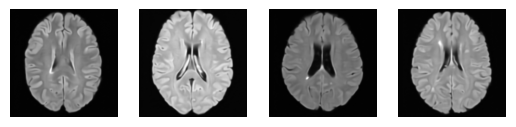

In [10]:
print(decoded.shape)
# plot
import matplotlib.pyplot as plt

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(decoded[i][0].squeeze().detach().numpy(), cmap="gray")
    plt.axis("off")
plt.show()

In [48]:
# Read the images /home/benet/data/VH2D/images/latent_flair/641_5_latent_1.npy
import torch
from torchvision.transforms import ToTensor

# Load images in grayscale mode
lat0 = np.load('/home/benet/data/VH2D/images/latent_flair/641_5_latent_0.npy')
lat1 = np.load('/home/benet/data/VH2D/images/latent_flair/641_5_latent_1.npy')
lat2 = np.load('/home/benet/data/VH2D/images/latent_flair/641_5_latent_2.npy')
lat3 = np.load('/home/benet/data/VH2D/images/latent_flair/641_5_latent_3.npy')

# Convert to tensor and remove the extra channel using .squeeze(0)
latents = torch.stack([
    ToTensor()(lat0).squeeze(0),  # Shape [32, 32]
    ToTensor()(lat1).squeeze(0),
    ToTensor()(lat2).squeeze(0),
    ToTensor()(lat3).squeeze(0)
], dim=0)  # Shape: [4, 32, 32]

# Add batch dimension
latents = latents.unsqueeze(0)  # Final Shape: [1, 4, 32, 32]

print(latents.shape)


torch.Size([1, 4, 32, 32])


In [49]:
decoded = vae.decode(latents).sample # Add batch dim

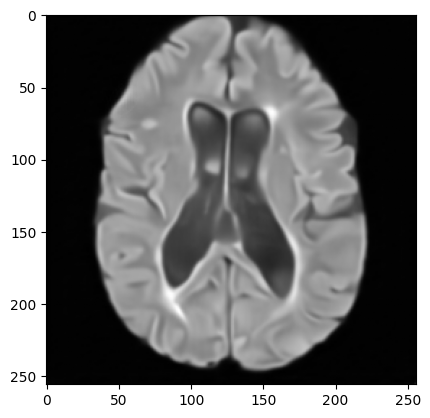

In [19]:
import matplotlib.pyplot as plt

plt.imshow(decoded[0][0].detach().cpu().numpy(), cmap='gray')

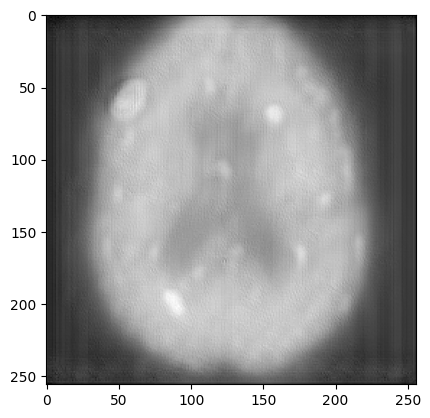

In [11]:
import matplotlib.pyplot as plt

# Plot the decoded images
plt.imshow(decoded[0][0].detach().numpy(), cmap='gray')
plt.show()

In [46]:
from PIL import Image

class LatentImageProcessor:
    def __init__(self, repo_path, vae, input_dir = "/home/benet/data/VH2D/images/flair", output_dir = "/home/benet/data/VH2D/images/latent_flair", resolution = 256): 
        self.repo_path = repo_path
        self.resolution = resolution
        self.vae = vae
        
        # Dataset and Latent Directory Setup
        self.input_dir = input_dir
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

        # Define the image preprocessing pipeline
        self.preprocess = Compose(
            [
                Resize(self.resolution, interpolation=InterpolationMode.BILINEAR), 
                CenterCrop(self.resolution),  # Center crop to the desired squared resolution
                ToTensor(),  # Convert to PyTorch tensor
                Normalize(mean=[0.5], std=[0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
            ]
        )

        # Device setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device: {self.device}")

        # Load VAE model
        pipeline_dir = self.repo_path / 'results/pipelines' / 'fintuned_vae'
        self.vae = AutoencoderKL.from_pretrained(pipeline_dir)
        self.vae.to(self.device).eval()

    def process_images(self):
        # Get image files from the dataset directory
        image_files = [f for f in os.listdir(self.input_dir) if f.endswith(".png")]
        print(f"Found {len(image_files)} images in the dataset folder")

        # Process each image and save latents
        with torch.no_grad():
            for image_file in image_files:
                img_path = os.path.join(self.input_dir, image_file)
                # Remove .png extension and add '_latent' in the image name
                image_file = image_file.split('.')[0] + "_latent"
                print(f"Processing {image_file}, {img_path}")
                image = Image.open(img_path).convert("RGB")

                image = self.preprocess(image).unsqueeze(0).to(self.device)
                latent = self.vae.encode(image).latent_dist.sample().squeeze(0)
                
                # Save the latent images
                latent = latent.cpu().numpy()
                for j in range(4):
                    plt.imshow(latent[j], cmap='gray')
                    plt.show()
                    plt.imsave(self.output_dir / f"{image_file}_{j}.png", latent[j])
                    # save as a matrix
                    np.save(self.output_dir / f"{image_file}_{j}.npy", latent[j])

                latent = latent.reshape(1, 4, 32, 32)
                # Convert latent to a PyTorch tensor and move it to the same device as the VAE
                latent = torch.tensor(latent, dtype=torch.float32, device=self.device)

                vae_latent = self.vae.decode(latent).sample

                # Convert back to NumPy for visualization
                vae_latent_np = vae_latent[0].detach().cpu().numpy().transpose(1, 2, 0)
                plt.imshow(vae_latent_np, cmap='gray')
                plt.show()
                
                break
            
            print(f"Latent images saved in {self.output_dir}")


Device: cuda
Found 570 images in the dataset folder
Processing 641_5_latent, /home/benet/data/VH2D/images/flair/641_5.png


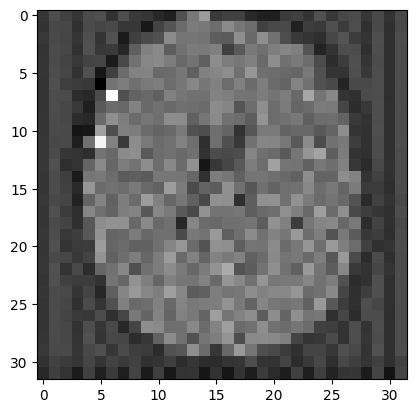

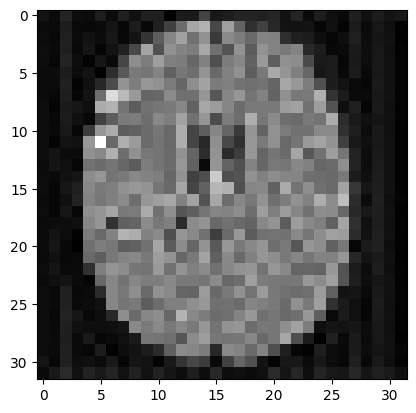

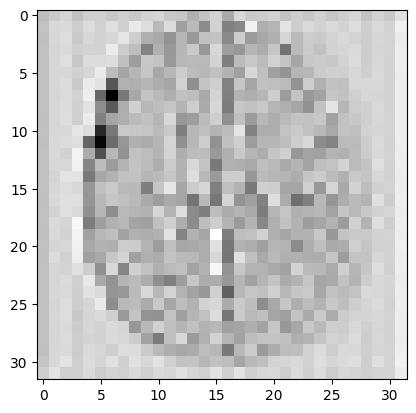

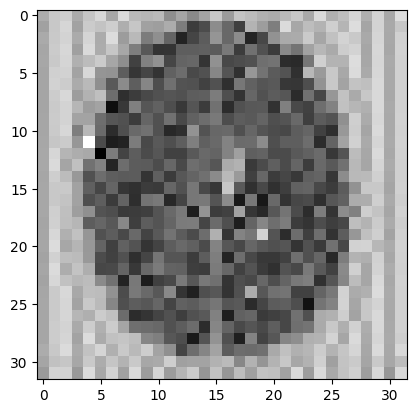

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0301902..0.8147887].


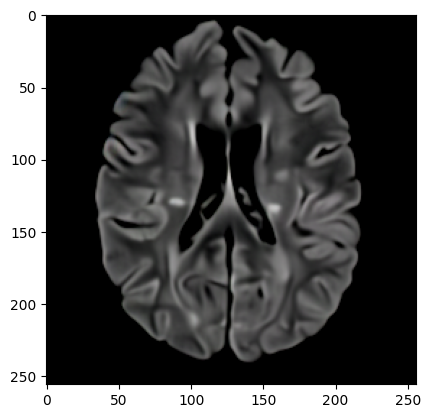

Latent images saved in /home/benet/data/VH2D/images/latent_flair


In [47]:
processor = LatentImageProcessor(repo_path, vae)
processor.process_images()